In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import glob
import pickle
from unittest import result
import numpy as np
import random
from tqdm import tqdm
from typing import cast
from music21 import converter, instrument, note, chord, stream
from music21.stream.base import Score
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation, BatchNormalization, Input, concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

*UPDATE ADAM TO RMSPROP TO COMPARE

In [ ]:
def prepare_sequences(notes, n_vocab):
	sequence_length = 128

	# get total vocab of component
	total_comp = sorted(set(item for item in notes))

	 # create a dictionary to map vocab to integers
	note_index_map = dict((note, number) for number, note in enumerate(total_comp))

	network_input = []
	network_output = []

	# create input sequences and outputs
	for i in range(0, len(notes) - sequence_length, 1):
		sequence_input = notes[i:i + sequence_length]
		sequence_output = notes[i + sequence_length]
		network_input.append([note_index_map[char] for char in sequence_input])
		network_output.append(note_index_map[sequence_output])

	n_patterns = len(network_input)

	# reshape for LSTM compatibility
	network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))

	# normalise input
	network_input = network_input / float(n_vocab)

	network_output = to_categorical(network_output)

	return (network_input, network_output)

In [ ]:
def create_input_branch(input_data, name, lstm_units=256, dropout_rate=0.2):

    input_layer = Input(shape=(input_data.shape[1], input_data.shape[2]), name=f"input_{name}")
    x = LSTM(
        lstm_units,
        return_sequences=True,
        name=f"lstm_{name}"
    )(input_layer)
    x = Dropout(dropout_rate, name=f"dropout_{name}")(x)

    return input_layer, x

In [ ]:
def create_output_branch(x, n_vocab, name, dense_units=128, dropout_rate=0.3):

    x = Dense(dense_units, activation='relu', name=f"dense_{name}")(x)
    x = BatchNormalization(name=f"bn_{name}")(x)
    x = Dropout(dropout_rate, name=f"dropout_{name}")(x)
    output = Dense(n_vocab, activation='softmax', name=name)(x)

    return output

In [ ]:
def create_network(network_input_notes, n_vocab_notes,
                  network_input_durations, n_vocab_durations,
                  network_input_offsets, n_vocab_offsets):

    # Create input branches
    input_notes_layer, input_notes = create_input_branch(network_input_notes, "notes")
    input_durations_layer, input_durations = create_input_branch(network_input_durations, "durations")
    input_offsets_layer, input_offsets = create_input_branch(network_input_offsets, "offsets")

    # Concatenate the three input branches
    combined = concatenate([input_notes, input_durations, input_offsets], name="combined_features")

    # Process combined features
    x = LSTM(512, return_sequences=True, name="lstm_combined_1")(combined)
    x = Dropout(0.3, name="dropout_combined_1")(x)
    x = LSTM(512, name="lstm_combined_2")(x)
    x = BatchNormalization(name="bn_combined")(x)
    x = Dropout(0.3, name="dropout_combined_2")(x)
    x = Dense(256, activation='relu', name="dense_combined")(x)

    # Create output branches
    output_notes = create_output_branch(x, n_vocab_notes, "Note")
    output_durations = create_output_branch(x, n_vocab_durations, "Duration")
    output_offsets = create_output_branch(x, n_vocab_offsets, "Offset")

    # Create and compile model
    model = Model(
        inputs=[input_notes_layer, input_durations_layer, input_offsets_layer],
        outputs=[output_notes, output_durations, output_offsets]
    )

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'accuracy', 'accuracy'])

    return model

In [ ]:
def train(model, network_input_notes, network_input_durations, network_input_offsets,
          network_output_notes, network_output_durations, network_output_offsets,
          validation_split=0.2):
    """ Train the neural network, now with a validation set """
    filepath = Path("/content/drive/MyDrive/finalyearproject/weights/optimisercomp/weights-adam-{epoch:02d}-{loss:.4f].keras")

    checkpoint = ModelCheckpoint(
        filepath,
        monitor='loss',
        verbose=0,
        save_best_only=True,
        mode='min'
    )

    early_stopping = EarlyStopping(
        monitor='loss',
        patience=10,
        restore_best_weights=True
    )
    callbacks_list = [early_stopping]

    # After preparing all network_inputs and outputs:
    indices = np.arange(len(network_input_notes))
    np.random.shuffle(indices)

    # Apply shuffle to all inputs and outputs
    network_input_notes = network_input_notes[indices]
    network_input_durations = network_input_durations[indices]
    network_input_offsets = network_input_offsets[indices]
    network_output_notes = network_output_notes[indices]
    network_output_durations = network_output_durations[indices]
    network_output_offsets = network_output_offsets[indices]

    # Include validation_split here so that validation metrics are tracked
    history = model.fit(
        [network_input_notes, network_input_durations, network_input_offsets],
        [network_output_notes, network_output_durations, network_output_offsets],
        epochs=100,
        batch_size=256,
        validation_split=validation_split,
        callbacks=callbacks_list,
        verbose=1
    )
    return history

In [ ]:
def plot_training_history(history):
    """Plot training & validation loss and accuracy values"""
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Plot training & validation loss values
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])

    ax1.set_title('Adam Loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper right')
    ax1.grid(True)

    # Plot overall accuracy instead of individual outputs
    if 'accuracy' in history.history and 'val_accuracy' in history.history:
        ax2.plot(history.history['accuracy'])
        ax2.plot(history.history['val_accuracy'])
        ax2.legend(['Train', 'Validation'], loc='lower right')
    else:
        # If overall accuracy is not available, calculate average accuracy across outputs
        outputs = ['Note', 'Duration', 'Offset']
        train_acc_avg = []
        val_acc_avg = []

        for i in range(len(history.history['loss'])):
            epoch_train_accs = []
            epoch_val_accs = []

            for output in outputs:
                acc_key = f'{output}_accuracy'
                val_acc_key = f'val_{output}_accuracy'

                if acc_key in history.history and val_acc_key in history.history:
                    epoch_train_accs.append(history.history[acc_key][i])
                    epoch_val_accs.append(history.history[val_acc_key][i])

            train_acc_avg.append(np.mean(epoch_train_accs))
            val_acc_avg.append(np.mean(epoch_val_accs))

        ax2.plot(train_acc_avg)
        ax2.plot(val_acc_avg)
        ax2.legend(['Train', 'Validation'], loc='lower right')

    ax2.set_title('Adam Accuracy')
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.grid(True)

    # Save the figure
    plt.tight_layout()
    plt.savefig("/content/drive/MyDrive/finalyearproject/optimisercomp/plots/training_history_adam.png")
    plt.show()

In [ ]:
def train_network():
    """ Train a Neural Network to generate music """

    notes_file = Path("/content/drive/MyDrive/finalyearproject/notes/notes7.pkl")
    notes = []
    with open(notes_file, "rb") as file:
        notes = pickle.load(file)

    # Get vocabularies (with fraction handling)
    # Extract individual components for each note
    all_pitches = []
    all_durations = []
    all_offsets = []
    for item in notes:
        parts = item.split(":")
        all_pitches.append(parts[0])
        all_durations.append(parts[1])
        all_offsets.append(parts[2])

    pitchnames = sorted(set(all_pitches))
    durations = sorted(set(all_durations))  # all_durations contains original strings
    offsets = sorted(set(all_offsets))

    n_vocab_offsets = len(offsets)
    network_input_offsets, network_output_offsets = prepare_sequences(all_offsets, n_vocab_offsets)

    n_vocab_notes = len(pitchnames)
    network_input_notes, network_output_notes = prepare_sequences(all_pitches, n_vocab_notes)

    n_vocab_durations = len(durations)
    network_input_durations, network_output_durations = prepare_sequences(all_durations, n_vocab_durations)

    model = create_network(network_input_notes, n_vocab_notes, network_input_durations, n_vocab_durations, network_input_offsets, n_vocab_offsets)

    # Print model summary
    # model.summary()

    # Train the model and get history
    history = train(model, network_input_notes, network_input_durations, network_input_offsets,
                   network_output_notes, network_output_durations, network_output_offsets)

    # Plot training history
    plot_training_history(history)

    # Optional: Save final model
    model.save(Path("/content/drive/MyDrive/finalyearproject/optimisercomp/models/final_model_adam.keras"))

    # Save history for later analysis if needed
    # with open("/content/drive/MyDrive/finalyearproject/training_history.pkl", 'wb') as file:
    #     pickle.dump(history.history, file)

    return model, history

Epoch 1/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 33s 57ms/step - Duration_accuracy: 0.4045 - Duration_loss: 2.7378 - Note_accuracy: 0.0334 - Note_loss: 5.4065 - Offset_accuracy: 0.3203 - Offset_loss: 3.2674 - loss: 11.4117 - val_Duration_accuracy: 0.4865 - val_Duration_loss: 1.5877 - val_Note_accuracy: 0.0447 - val_Note_loss: 4.5139 - val_Offset_accuracy: 0.3557 - val_Offset_loss: 1.6643 - val_loss: 7.7658
Epoch 2/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 55ms/step - Duration_accuracy: 0.4946 - Duration_loss: 1.4971 - Note_accuracy: 0.0636 - Note_loss: 4.2878 - Offset_accuracy: 0.4441 - Offset_loss: 1.5097 - loss: 7.2946 - val_Duration_accuracy: 0.5293 - val_Duration_loss: 1.4587 - val_Note_accuracy: 0.0827 - val_Note_loss: 4.1414 - val_Offset_accuracy: 0.4881 - val_Offset_loss: 1.3811 - val_loss: 6.9812
Epoch 3/100
444/444 ━━━━━━━━━━━━━━━━━━━━ 24s 54ms/step - Duration_accuracy: 0.5113 - Duration_loss: 1.4641 - Note_accuracy: 0.0704 - Note_loss: 4.2323 - Offset_accuracy: 0.4606 - Offset_loss: 1.457

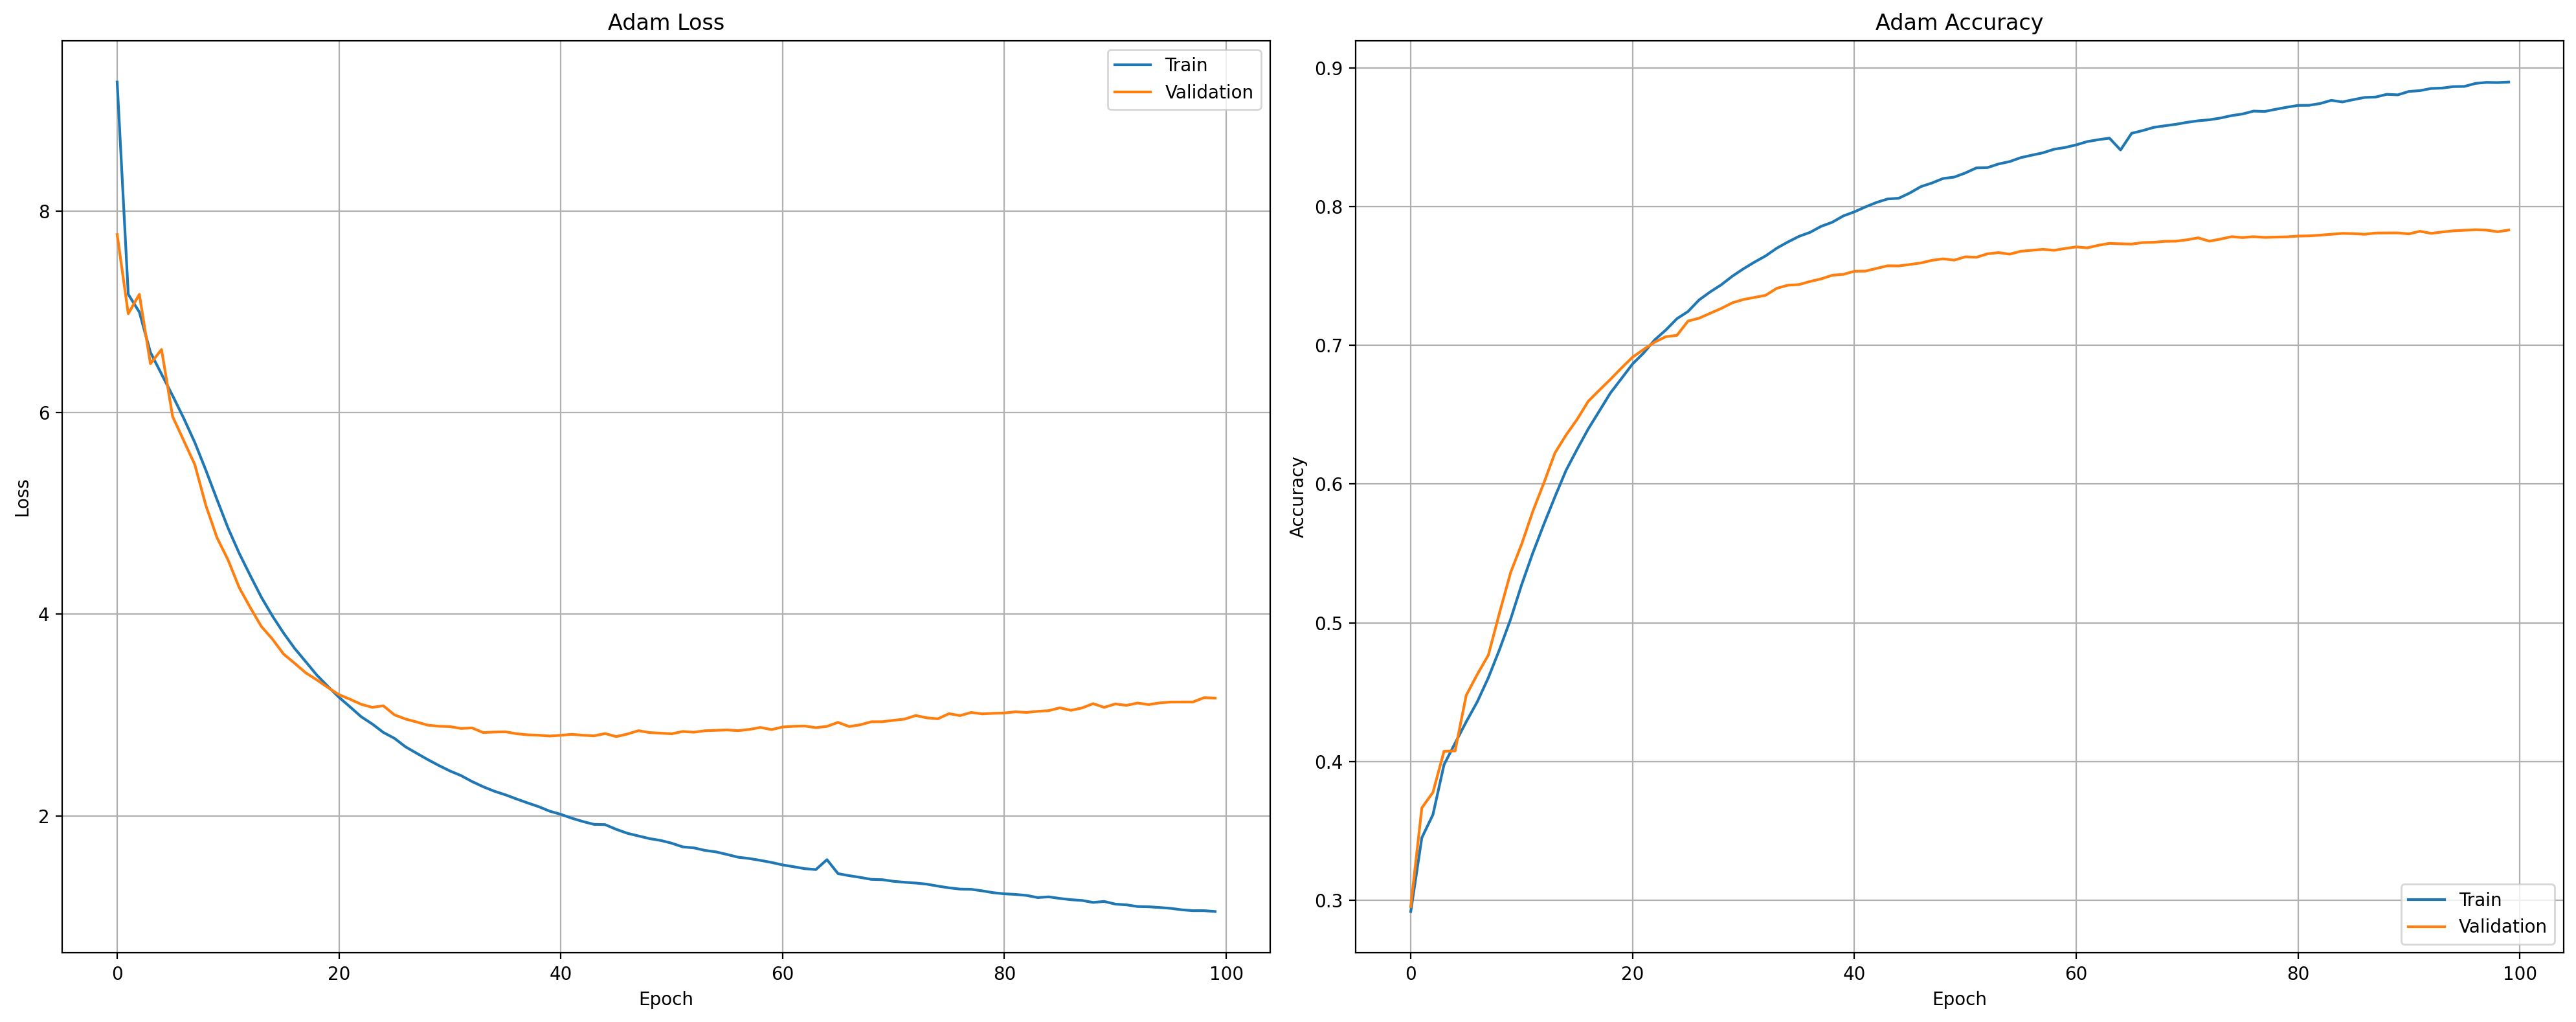

In [ ]:
model, history = train_network()